In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

16:01:08 - cmdstanpy - INFO - Chain [1] start processing
16:01:08 - cmdstanpy - INFO - Chain [1] done processing


Prophet
     Scenario  HorizonDays  TotalSpend  PredOrders  ProjectedCAC
1   +20% Flat           28   3241908.0      3684.0        880.00
2  +20% Smart           28   3241908.0      3684.0        880.00
0    Baseline           28   2701590.0      2740.2        985.92


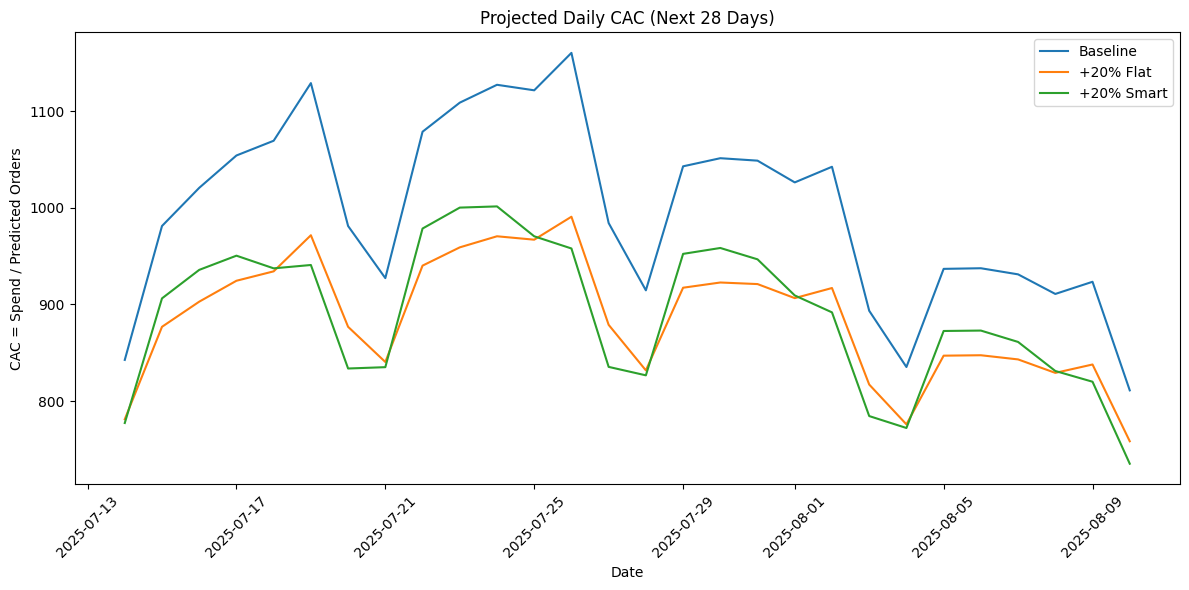

In [7]:


# ---- Load ----
path_opts = [
    "wbr_global_data.csv",
]
for p in path_opts:
    if os.path.exists(p):
        PATH = p; break

df = pd.read_csv(PATH)
df.columns = [c.lower() for c in df.columns]
df["ds"] = pd.to_datetime(df["date"])
df = df.sort_values("ds")
data = df.rename(columns={"daily_spend":"spend"})[["ds","spend","orders"]].copy()
data["spend"]  = pd.to_numeric(data["spend"], errors="coerce").clip(lower=0)
data["orders"] = pd.to_numeric(data["orders"], errors="coerce").clip(lower=0)
data["cac"]    = np.where(data["orders"]>0, data["spend"]/data["orders"], np.nan)

# ---- Weekday efficiency (inverse-CAC weights) ----
wk = (data.assign(weekday=data["ds"].dt.day_name())
           .groupby("weekday", as_index=False)
           .agg(cac_median=("cac","median")))
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
wk["weekday"] = pd.Categorical(wk["weekday"], categories=order, ordered=True)
wk = wk.sort_values("weekday")
wk["w"] = 1.0 / wk["cac_median"].replace(0, np.nan)
wk["w"] = wk["w"].fillna(wk["w"].median())
wk["w"] = wk["w"] / wk["w"].sum()
wmap = dict(zip(wk["weekday"].astype(str), wk["w"]))

# ---- Baseline spend template (last 28d median per weekday) ----
recent = data[data["ds"] >= data["ds"].max() - pd.Timedelta(days=27)]
base_map = (recent.assign(weekday=recent["ds"].dt.day_name())
                  .groupby("weekday", as_index=False)
                  .agg(baseline=("spend","median")))
base_map["weekday"] = pd.Categorical(base_map["weekday"], categories=order, ordered=True)
base_map = base_map.sort_values("weekday")
base_spend = dict(zip(base_map["weekday"].astype(str), base_map["baseline"]))

# ---- Scenarios ----
H = 28
future = pd.DataFrame({"ds": pd.date_range(start=data["ds"].max()+pd.Timedelta(days=1), periods=H)})
future["weekday"] = future["ds"].dt.day_name()

scenA = future.copy(); scenA["spend"] = scenA["weekday"].map(base_spend)
scenB = future.copy(); scenB["spend"] = scenB["weekday"].map(base_spend) * 1.20
totB = scenB["spend"].sum()
daily_w = future["weekday"].map(wmap).values; daily_w = daily_w/daily_w.sum()
scenC = future.copy(); scenC["spend"] = totB * daily_w

# ---- Model: Prophet if available, else ridge ----

# Global model handle for accuracy testing later
m = None

if have_prophet():
    # Build & fit ONCE globally
    try:
        from prophet import Prophet as _Prophet
    except Exception:
        from fbprophet import Prophet as _Prophet

    _train = data.rename(columns={"orders":"y"})[["ds","y","spend"]]
    m = _Prophet(weekly_seasonality=True, yearly_seasonality=True)
    m.add_regressor("spend")
    m.fit(_train)


def predict_orders_prophet(history, scen_dict):
    """Use the already-fitted global Prophet model `m`. Returns (preds, m, name)."""
    assert m is not None, "Global Prophet model `m` is not fitted."
    out = {}
    for k, f in scen_dict.items():
        fc = m.predict(f[["ds","spend"]])
        o = f.copy()
        o["pred_orders"] = fc["yhat"].clip(lower=0)
        out[k] = o
    return out, m, "Prophet"


def predict_orders_reg(history, scen_dict):
    from sklearn.linear_model import Ridge
    h = history.copy()
    h["trend"] = (h["ds"] - h["ds"].min()).dt.days
    h["dow"] = h["ds"].dt.dayofweek
    X = pd.get_dummies(h[["trend","dow"]].astype({"dow":"category"}), drop_first=True)
    X["log_spend"] = np.log1p(h["spend"])
    y = np.log1p(h["orders"])  # stabilize variance
    mdl = Ridge(alpha=1.0).fit(X, y)
    out = {}
    for k, f in scen_dict.items():
        g = f.copy()
        g["trend"] = (g["ds"] - h["ds"].min()).dt.days
        g["dow"] = g["ds"].dt.dayofweek
        Xf = pd.get_dummies(g[["trend","dow"]].astype({"dow":"category"}), drop_first=True)
        for col in X.columns:
            if col not in Xf.columns:
                Xf[col] = 0
        Xf = Xf[X.columns]
        Xf["log_spend"] = np.log1p(g["spend"])
        g["pred_orders"] = np.expm1(mdl.predict(Xf)).clip(lower=0)
        out[k] = g
    return out, mdl, "Ridge"

scenarios = {"Baseline":scenA, "+20% Flat":scenB, "+20% Smart":scenC}

if m is not None:
    preds, _m, model_name = predict_orders_prophet(data, scenarios)
else:
    preds, _m, model_name = predict_orders_reg(data, scenarios)

# ---- Summaries ----
rows = []
for k, d in preds.items():
    tot_spend = d["spend"].sum()
    tot_orders = d["pred_orders"].sum()
    cac = tot_spend / tot_orders if tot_orders>0 else np.nan
    rows.append({"Scenario":k,"HorizonDays":H,"TotalSpend":round(tot_spend,2),
                 "PredOrders":round(tot_orders,1),"ProjectedCAC":round(cac,2)})
summary = pd.DataFrame(rows).sort_values("Scenario"); print(model_name); print(summary)

# ---- Plot ----
plt.figure(figsize=(12,6))
for k, d in preds.items():
    plt.plot(d["ds"], d["spend"]/d["pred_orders"], label=k)
plt.title("Projected Daily CAC (Next 28 Days)")
plt.xlabel("Date"); plt.ylabel("CAC = Spend / Predicted Orders"); plt.legend(); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


In [8]:
# Combine all scenarios into one comparison table
compare = future[["ds","weekday"]].copy()
compare["Baseline"]     = scenA["spend"].values
compare["+20% Flat"]    = scenB["spend"].values
compare["+20% Smart"]   = scenC["spend"].values

print(compare.head(28))   # show all 28 days

           ds    weekday  Baseline  +20% Flat     +20% Smart
0  2025-07-14     Monday  101309.5   121571.4  123260.630517
1  2025-07-15    Tuesday  101883.0   122259.6  115223.074745
2  2025-07-16  Wednesday   98638.0   118365.6  111567.975951
3  2025-07-17   Thursday   95625.5   114750.6  109871.320974
4  2025-07-18     Friday   92712.0   111254.4  110673.798483
5  2025-07-19   Saturday   90538.0   108645.6  113997.583073
6  2025-07-20     Sunday   94691.5   113629.8  125882.616258
7  2025-07-21     Monday  101309.5   121571.4  123260.630517
8  2025-07-22    Tuesday  101883.0   122259.6  115223.074745
9  2025-07-23  Wednesday   98638.0   118365.6  111567.975951
10 2025-07-24   Thursday   95625.5   114750.6  109871.320974
11 2025-07-25     Friday   92712.0   111254.4  110673.798483
12 2025-07-26   Saturday   90538.0   108645.6  113997.583073
13 2025-07-27     Sunday   94691.5   113629.8  125882.616258
14 2025-07-28     Monday  101309.5   121571.4  123260.630517
15 2025-07-29    Tuesday

In [9]:
# ---- Export CSVs ----
# Detailed daily forecast across scenarios
all_fcst = []
for scen, df_scen in preds.items():
    tmp = df_scen.copy()
    tmp["Scenario"] = scen
    all_fcst.append(tmp)
forecast_df = pd.concat(all_fcst, ignore_index=True)
data.to_csv("loaded_data.csv", index=False)
forecast_df.to_csv("forecast_daily.csv", index=False)
summary.to_csv("scenario_summary.csv", index=False)

In [10]:
hist_days = (data["ds"].max() - data["ds"].min()).days + 1
print(hist_days)

560


In [11]:
# ======================
# ACCURACY (CV on history)
# ======================
# Rolling-origin CV: evaluate how well the model predicts y (orders) on held-out windows.
cv = cross_validation(m, horizon="28 days", period="14 days", initial="400 days")
pm = performance_metrics(cv)  # columns include rmse, mape, mae, etc.

# Print per-horizon averages (like your screenshot)
acc_by_h = pm[["horizon","rmse","mape","mae"]].groupby("horizon", as_index=True).mean()
print("\nAccuracy by horizon (mean across folds):")
print(acc_by_h)

# Also print overall means for quick read
overall = pm[["rmse","mape","mae"]].mean().to_dict()
print("\nOverall CV means:", {k: round(v, 4) for k, v in overall.items()})

# Save metrics
pm.to_csv("prophet_cv_metrics.csv", index=False)
acc_by_h.reset_index().to_csv("prophet_cv_metrics_by_horizon.csv", index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

16:01:23 - cmdstanpy - INFO - Chain [1] start processing
16:01:23 - cmdstanpy - INFO - Chain [1] done processing
16:01:23 - cmdstanpy - INFO - Chain [1] start processing
16:01:23 - cmdstanpy - INFO - Chain [1] done processing
16:01:23 - cmdstanpy - INFO - Chain [1] start processing
16:01:23 - cmdstanpy - INFO - Chain [1] done processing
16:01:23 - cmdstanpy - INFO - Chain [1] start processing
16:01:23 - cmdstanpy - INFO - Chain [1] done processing
16:01:23 - cmdstanpy - INFO - Chain [1] start processing
16:01:23 - cmdstanpy - INFO - Chain [1] done processing
16:01:23 - cmdstanpy - INFO - Chain [1] start processing
16:01:23 - cmdstanpy - INFO - Chain [1] done processing
16:01:24 - cmdstanpy - INFO - Chain [1] start processing
16:01:24 - cmdstanpy - INFO - Chain [1] done processing
16:01:24 - cmdstanpy - INFO - Chain [1] start processing
16:01:24 - cmdstanpy - INFO - Chain [1] done processing
16:01:24 - cmdstanpy - INFO - Chain [1] start processing
16:01:24 - cmdstanpy - INFO - Chain [1]


Accuracy by horizon (mean across folds):
              rmse      mape        mae
horizon                                
3 days   25.512799  0.184016  18.835936
4 days   23.143449  0.176456  17.122053
5 days   26.398249  0.176997  18.102570
6 days   28.019311  0.195185  21.095923
7 days   32.950189  0.235029  27.295735
8 days   35.208322  0.259511  31.613245
9 days   39.647702  0.254524  31.884146
10 days  65.054859  0.292042  40.153780
11 days  88.021602  0.318195  44.980631
12 days  84.124031  0.317049  42.366757
13 days  63.612513  0.272521  31.096990
14 days  30.395390  0.219748  23.783499
15 days  24.580545  0.176813  20.164088
16 days  25.459807  0.185787  21.191095
17 days  29.748292  0.232033  24.066378
18 days  31.900899  0.241812  25.432212
19 days  36.151157  0.239563  26.532359
20 days  36.442483  0.229742  26.781727
21 days  42.996182  0.261216  32.230769
22 days  48.739624  0.271716  36.570228
23 days  57.491845  0.268867  37.389820
24 days  76.767038  0.314560  46.05356

In [12]:
print(m)